## Template code to ingest data and create a covariance matrix of indicators

In [1]:
import pandas as pd
import openpyxl
import numpy as np
from datetime import datetime
import xlsxwriter
import string
import os
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from functools import reduce
import sys
import warnings
from datetime import timedelta
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import statsmodels.api as sm
from scipy.stats import norm
import math
import regreg.api as rr
import pylab
from scipy import sparse
import cvxpy as cp
from sklearn.metrics import silhouette_samples
from sklearn.neighbors.kde import KernelDensity
from scipy.optimize import minimize
import matplotlib.pyplot as mpl,seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import VAR
import statsmodels.api as sm#,statsmodels as sm1

### Parameters and lambdas

In [2]:
## what are we trading

p_contract =  "EURUSD"

## Specify lookbacks for averages etc.
lb0 = 1
lb1 = 7
lb2 = 14
lb3 = 21
lb4 = 30
lb5 = 180
lb_list =[lb1,lb2,lb3,lb4,lb5]

##Specify short term volatility bounds

stv1 = 3
stv2 = 7
stv_list = [stv1,stv2]
gain_threshold = 0.001
threshold_test = 0.95
p_min = 7 #Days 
p_max = 40 #Days
rolling_av_min = 7
rolling_av_max = 100
pip_margin = 0.0003

##Specify flat range
flat_min = 0.01 ##express in pct

## specify window and shift ranges
window_range = range(3,35)
shift_range = range(1,25)
min_data_points = 100


## Specify helper lambdas
convert_string_to_datetime = lambda x: datetime.strptime(x,"%Y-%m-%d")
status_calc = lambda x: 'Up' if x> flat_min/2 else 'Down'if x<flat_min/2*(-1) else 'Flat'
up_down_calc = lambda x: "Up" if x >0 else "Down"
modulus = lambda x: -1*x if x<0 else x
is_positive = lambda x: "Positive" if x > gain_threshold else "Negative"
purchase_status_calc = lambda x: "Buy" if x == 1  else "Sell"
purchase_status_calc_bin = lambda x: 1 if x > gain_threshold else 0
momentum_status_calc_bin = lambda x: 0 if x <= 0 else 1

### Helper functions

In [3]:
## Form of function = "calc_"+ indicator name in x / y variables.

def self_reference(f):
    f.__defaults__ = f.__defaults__[:-1] + (f,)
    return f

@self_reference
def calc_momentum(df,price,window,self=None):
    df['last_%s_momentum' % window] = (df[price] / df[price].shift(window))-1
    string = 'last_%s_momentum' % window
    return df,string

@self_reference
def calc_rolling_avg_pct_change(df,price,window,shift,self=None):
    string = "rolling_"+str(window)+"_avg_"+str(shift)+"_period_pct_change"
    df[string] = df[price].rolling(window).mean()
    df[string] = (df[string]/df[string].shift(shift))-1
    
    return df,string

@self_reference
def calc_rolling_avg(df,price,window,self=None):
    df['rolling_%s_avg_price' % window] = df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price' % window
    return df,string
 
@self_reference    
def calc_rolling_avg_price_dif(df,price,window,self=None):
    df['rolling_%s_avg_price_dif' % window] = df[price] - df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price_dif' % window
    return df,string

@self_reference
def calc_RSI(df,price,window,self=None):
    random = df.copy(deep = True)
    random['status'] = random[price] - random[price].shift(1)
    random['status'] = random['status'].apply(lambda x: "Up" if x > 0 else "Down")
    random['average_for_up'] = random['status'].apply(lambda x: 1 if x == "Up" else 0)
    random['average_for_down'] = random['status'].apply(lambda x: 0 if x == "Up" else 1)
    random['average_price_up'] = (random['price']-random['price'].shift(1)) * random['average_for_up']
    random['average_price_down'] = (random['price']-random['price'].shift(1))* random['average_for_down']*-1
    random['average_price_up'] = random['average_price_up'].apply(lambda x: None if x ==  0 else x )
    random['average_price_down'] = random['average_price_down'].apply(lambda x: None if x == 0 else x )
    random['last_%s_RSI' % window] = random['average_price_up'].rolling(window, min_periods =1).sum() / random['average_price_down'].rolling(window, min_periods =1).sum()
    df['last_%s_RSI' % window] = 1 - 1/(1+random['last_%s_RSI' % window])
    for item in range(0,window): ## Formula above will not give NANs for the first (window-1) terms as min_periods = 1.
        df.at[item,'last_%s_RSI' % window] = None
    output_string = "last_" + str(window)+"_RSI"
    
    return df,output_string

@self_reference
def calc_forward_opportunity(df,price,window,self=None):
    df['forward_%s_opportunity' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity' % window] = df['forward_%s_opportunity' % window].shift(-window) - df[price]
    string = 'forward_%s_opportunity' % window
    return df,string 

calc_momentum.type = "window"
calc_rolling_avg_pct_change.type = "window_shift"
calc_rolling_avg.type = "window"
calc_rolling_avg_price_dif.type = "window"
calc_RSI.type="window"
calc_forward_opportunity.type = "window"

### specify function list; must be ordered:



### Helper functions from ML for AM

In [4]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    #print(pdf)
    #print(type(pdf))
    #print(np.shape(pdf))
    #print(np.shape(np.reshape(pdf, newshape = 1000)))
    #print(q)
    #print(eVal)
    #print(len(pdf))
    
    pdf=pd.Series(np.reshape(pdf,1000),index=np.reshape(eVal,len(eVal))) ## necessary to reshape array from (R,1) to (R,)
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

def getRndCov(nCols,nFacts):
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    #return pdf0
    return sse
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    #fun = errPDFs(x,eVal,q,bWidth)
    #out=minimize(fun(eVal,q,bWidth))
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
# Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
    return corr2

def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

def simCovMu(mu0,cov0,nObs,shrink=False): # When shrink=True, the function performs a Ledoit–Wolf shrinkage of the empirical covariance matrix.
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1


def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

### Indicator specification

In [5]:
### Specify what indicators to use
### These variables should be iterable based on either a shift or a rolling window.It may be iterable multiple times
x_variables = ['momentum','rolling_avg_pct_change','rolling_avg','rolling_avg_price_dif','RSI']
y_variables = ['forward_opportunity']
all_variables = x_variables + y_variables
x_dic = {}
for item in x_variables:
    x_dic[item] = eval("calc_"+str(item))
    
y_dic = {}
for item in y_variables:
    y_dic[item] = eval("calc_"+str(item))

### Upload data

In [6]:
## Directory params
p_file_path =  r"C:\Users\hugo.lu\repos\repos_backup\ib_insync\Raw data\\" + p_contract + "\\"
data_list = os.listdir(path=p_file_path)
data_sub_list = []
if len(data_list) == 0:
    print("Nothing in directory")
    directory_empty = True
else:
    for item in data_list:
        try:
            data_sub_list.append(datetime.strptime(item.split("_")[0],"%Y-%m-%d"))
        except:
            data_sub_list.append(datetime.strptime('1000-01-01',"%Y-%m-%d"))
### Take latest file            
    m = max(data_sub_list)
    index_out = [i for i, j in enumerate(data_sub_list) if j == m]

    print("The index of the latest data is: " + str(index_out))

    data_load_string = data_list[0]
    data_in = pd.read_csv(filepath_or_buffer = r'C:\Users\hugo.lu\repos\repos_backup\ib_insync\Raw data\\' + p_contract + "\\" + data_load_string

                         ,index_col=0)
    ### Convert date column to datetime64
    data_in['date'] = data_in['date'].astype(str) 
    data_in['date']=data_in['date'].apply(convert_string_to_datetime)

The index of the latest data is: [0]


In [7]:
data_columns = list(data_in.columns)
data_copy = data_in.copy(deep = True)
data_copy = data_copy.rename( columns = {
    
    'date': 'date',
    'open':'price',
    #'Ticker':'ticker'
    
})
data_copy['ticker'] = "EURUSD"
## Cast all relevant objects to floats

float_list = ['price','close']

for item in float_list:
    data_copy[item] = data_copy[item].astype('float64')
    ## Cast all relevant objects to dates

float_list = ['date']
for item in float_list:
    data_copy[item] = pd.to_datetime(data_copy[item])

### Calculate technical indicators

In [9]:
x_variables_actual = []
y_variables_actual = []
for item in window_range:
    for key,value in x_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            
            [data_copy,b] = value(data_copy,'price',item)
            x_variables_actual.append(b)
        elif value.type == "window_shift":
            for jtem in shift_range:
                [data_copy,b] = value(data_copy,'price',item,jtem)
                x_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break
            
for item in window_range:
    for key,value in y_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            
            [data_copy,b] = value(data_copy,'price',item)
            y_variables_actual.append(b)
        elif value.type == "window_shift":
            for jtem in shift_range:
                [data_copy,b] = value(data_copy,'price',item,jtem)
                y_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break
all_variables_list = x_variables_actual+y_variables_actual

### Calculate covariance matrix and cleaned data

In [10]:

data_reg = data_copy[all_variables_list]
data_reg = data_reg.dropna() ### Simply dropna as data availability is not an issue

### Regularise data

In [11]:
data_mean = list(data_reg.mean())
data_std = list(data_reg.std())
data_reg = (data_reg - data_mean)/data_std


### Test for stationarity

In [12]:

## Test for stationarity; keep the columns at a given sig level
five_pct_confidence_adf = []
one_pct_confidence_adf = []
not_accepted_adf = []

from statsmodels.tsa.stattools import adfuller
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
for item in x_variables_actual:
    X = data_reg[item]
    result = adfuller(X)
    #print('ADF Statistic: %f' % result[0])
    #print('p-value: %f' % result[1])
    #print('Critical Values:')
    #for key, value in result[4].items():
    #    print('\t%s: %.3f' % (key, value))
    if result[0] < -3.434:
        five_pct_confidence_adf.append(item)
        one_pct_confidence_adf.append(item)
    elif result[0] < -2.863:
        five_pct_confidence_adf.append(item)
    else:
        not_accepted_adf.append(item)
print("Five pct has retention of: " + str(len(five_pct_confidence_adf)/len(list(data_reg.columns))))
print("One pct has retention of: " + str(len(one_pct_confidence_adf)/len(list(data_reg.columns))))

Five pct has retention of: 0.9310344827586207
One pct has retention of: 0.9310344827586207


In [14]:
stationary_data = data_reg[one_pct_confidence_adf+y_variables_actual]

In [15]:
list(stationary_data.columns)

['last_3_momentum',
 'rolling_3_avg_1_period_pct_change',
 'rolling_3_avg_2_period_pct_change',
 'rolling_3_avg_3_period_pct_change',
 'rolling_3_avg_4_period_pct_change',
 'rolling_3_avg_5_period_pct_change',
 'rolling_3_avg_6_period_pct_change',
 'rolling_3_avg_7_period_pct_change',
 'rolling_3_avg_8_period_pct_change',
 'rolling_3_avg_9_period_pct_change',
 'rolling_3_avg_10_period_pct_change',
 'rolling_3_avg_11_period_pct_change',
 'rolling_3_avg_12_period_pct_change',
 'rolling_3_avg_13_period_pct_change',
 'rolling_3_avg_14_period_pct_change',
 'rolling_3_avg_15_period_pct_change',
 'rolling_3_avg_16_period_pct_change',
 'rolling_3_avg_17_period_pct_change',
 'rolling_3_avg_18_period_pct_change',
 'rolling_3_avg_19_period_pct_change',
 'rolling_3_avg_20_period_pct_change',
 'rolling_3_avg_21_period_pct_change',
 'rolling_3_avg_22_period_pct_change',
 'rolling_3_avg_23_period_pct_change',
 'rolling_3_avg_24_period_pct_change',
 'rolling_3_avg_price_dif',
 'last_3_RSI',
 'last_4_m

### Test for autocorrelation

In [16]:

## Test for stationarity; keep the columns at a given sig level
five_pct_confidence_lb = []
one_pct_confidence_lb = []
ac_accepted_lb = []

from statsmodels.tsa.stattools import adfuller
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
for item in list(stationary_data.columns):
    X = data_reg[item]
    result = acorr_ljungbox(X,lags = 10)
    #print('ADF Statistic: %f' % result[0])
    #print('p-value: %f' % result[1])
    #print('Critical Values:')
    #for key, value in result[4].items():
    #    print('\t%s: %.3f' % (key, value))
    if result[1].min() < 0.01:
        five_pct_confidence_lb.append(item)
        one_pct_confidence_lb.append(item)
    elif result[1].min() < 0.05:
        five_pct_confidence_lb.append(item)
        
    else:
        ac_accepted_lb.apend(item)
print("Five pct has retention of: " + str(len(ac_accepted_lb)/len(list(stationary_data.columns))))
#print("One pct has retention of: " + str(len(one_pct_confidence_adf)/len(list(stationary_data.columns))))

Five pct has retention of: 0.0


### Consider fractional differencing

In [17]:

#### d is the amount to fractionally difference
def getFDWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w



### Observe covariance matrix properties

In [18]:
stationary_data.reset_index(inplace = True, drop = True)
data_covariance = stationary_data[one_pct_confidence_adf].copy(deep = True)

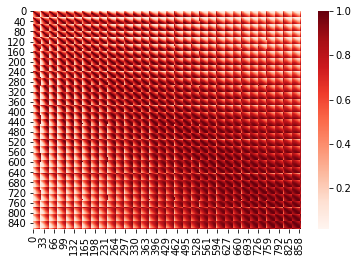

In [19]:
obs = len(data_covariance)
covariance_matrix = pd.DataFrame(np.array(data_covariance.T).dot(np.array(data_covariance)))/obs
sns.heatmap(covariance_matrix,cmap = "Reds")

In [20]:
correlation_matrix = cov2corr(covariance_matrix)

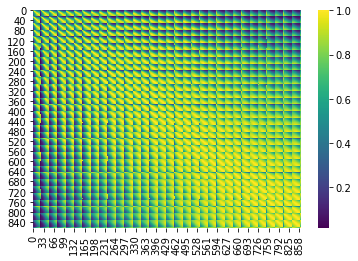

In [21]:
sns.heatmap(correlation_matrix,cmap = "viridis")

## Denoise matrix

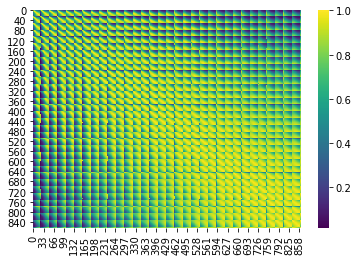

In [22]:
# Note - in this example there is little to denoise
q=(np.array(data_covariance).shape[0]/np.array(data_covariance).shape[1])
eVal0,eVec0=getPCA(correlation_matrix)
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01)
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)
sns.heatmap(corr1,cmap="viridis")
eMax0_denoise,var0_denoise=findMaxEval(np.diag(eVal1),q,bWidth=.01)

In [335]:
print("the signal to noise ratio is: " + str((1-var0_denoise)/var0_denoise))

the signal to noise ratio is: 1.0000100000954499e-05


In [23]:
print("the signal to noise ratio is: " + str((1-var0)/var0))

the signal to noise ratio is: 1.0000100000954499e-05


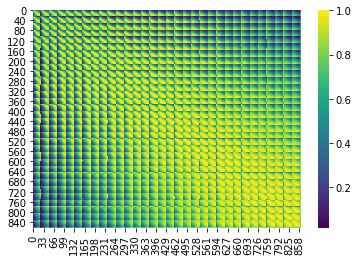

In [24]:
## instead of setting all eigenvectors that are random as a constant value, we may wish to target the shrinkage 
## This method is better in teh sense of retaining more signal but may have more noise too. Therefore it may be prudent to
## Apply both and choose the method that results in the better SNR in the denoised matrix? No. Because one necessarily has a
## higher ratio because all the noise is removed. We need to find which is better at predicting the original data.
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5)
eVal1,eVec1=getPCA(corr1)
sns.heatmap(corr1,cmap="viridis")
eMax0_denoise,var0_denoise=findMaxEval(np.diag(eVal1),q,bWidth=.01)

In [26]:
print("the signal to noise ratio is: " + str((1-var0_denoise)/var0_denoise))

the signal to noise ratio is: 1.0000100000954499e-05


### Cluster analysis

#### Definitions

In [337]:
 def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
     from sklearn.cluster import KMeans
     from sklearn.metrics import silhouette_samples
     dist,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series() # distance matrix
     for init in range(n_init):
            print(init)
            for i in range(2,maxNumClusters+1): # find optimal num clusters
                #print("the max clusters are: " + str (maxNumClusters+1))
                print("CHECKING CLUSTERS FOR: " + str(i))
                kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1)
                kmeans_=kmeans_.fit(dist)
                silh_=silhouette_samples(dist,kmeans_.labels_)
                stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
                if np.isnan(stat[1]) or stat[0]>stat[1]:
                    silh,kmeans=silh_,kmeans_
     n_clusters = len( np.unique( kmeans.labels_ ) )
     newIdx=np.argsort(kmeans.labels_)
     corr1=corr0.iloc[newIdx] # reorder rows
     corr1=corr1.iloc[:,newIdx] # reorder columns
     clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0] ].tolist() for i in np.unique(kmeans.labels_) } # cluster members
     silh=pd.Series(silh,index=dist.index)
     return corr1,clstrs,silh

    #------------------------------------------------------------------------------
def makeNewOutputs2(corr0,clstrs,clstrs2):
    from sklearn.metrics import silhouette_samples
    clstrsNew,newIdx={},[]
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    map(newIdx.extend, clstrsNew.values())
    corrNew=corr0.loc[newIdx,newIdx]

    dist=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs=[dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(dist,kmeans_labels),index=dist.index)
    return corrNew,clstrsNew,silhNew

def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew={}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    newIdx=[j for i in clstrsNew for j in clstrsNew[i]]
    corrNew=corr0.loc[newIdx,newIdx]
    x=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs=[x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(x,kmeans_labels),
    index=x.index)
    return corrNew,clstrsNew,silhNew
    #------------------------------------------------------------------------------
def clusterKMeansTop(corr0,maxNumClusters=10,n_init=10):
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters=min(maxNumClusters,corr0.shape[1]-1),n_init=n_init)
    clusterTstats={i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=sum(clusterTstats.values())/float(len(clusterTstats.values()))
    redoClusters=[i for i in clusterTstats.keys() if clusterTstats[i]<tStatMean]
    if len(redoClusters)<=2:
        return corr1,clstrs,silh
    else:
        keysRedo=[];#map(keysRedo.extend,[clstrs[i] for i in redoClusters])
        for item in redoClusters:
            for j in clstrs[item]:
                keysRedo.append(j)
        corrTmp=corr0.loc[keysRedo,keysRedo]
        meanRedoTstat=np.mean([clusterTstats[i] for i in redoClusters])
        corr2,clstrs2,silh2=clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters,corrTmp.shape[1]-1),n_init=n_init)
        # Make new outputs, if necessary
        #print("The length of the  inner returned matrix is: " + str(len(corr2)))
        corrNew,clstrsNew,silhNew=makeNewOutputs(corr0, {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},clstrs2)
        #print("The length of the  new cov matrix is: " + str(len(corrNew)))
        newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean<=meanRedoTstat:
            #print("Returning old correlation matrix")
            return corr1,clstrs,silh
        else:
            #print("Returning new correlation matrix")
            return corrNew,clstrsNew,silhNew

import numpy as np,pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
#------------------------------------------------------------------------------
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#------------------------------------------------------------------------------
def getCovSub(nObs,nCols,sigma,random_state=None):
    # Sub correl matrix
    rng = check_random_state(random_state)
    if nCols==1:return np.ones((1,1))
    ar0=rng.normal(size=(nObs,1))
    ar0=np.repeat(ar0,nCols,axis=1)
    ar0+=rng.normal(scale=sigma,size=ar0.shape)
    ar0=np.cov(ar0,rowvar=False)
    return ar0
#------------------------------------------------------------------------------
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    # Generate a random correlation matrix with a given number of blocks
    rng = check_random_state(random_state)
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)
    parts.sort()
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)
    parts=np.append(parts[0],np.diff( parts )) - 1 + minBlockSize
    cov=None
    for nCols_ in parts:
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)
        if cov is None:cov=cov_.copy()
        else:cov=block_diag(cov,cov_)
    return cov
#------------------------------------------------------------------------------
def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):
    # Form block covar
    rng = check_random_state(random_state)
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,\
    sigma=.5,random_state=rng) # perfect block corr
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,\
    sigma=1.,random_state=rng) # add noise
    cov0+=cov1
    corr0=cov2corr(cov0)
    corr0=pd.DataFrame(corr0)
    return corr0

#### Working

In [336]:
working_correlation = correlation_matrix

In [338]:
[corrNew,clstrsNew,silhNew] = clusterKMeansTop(working_correlation)

0
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
1
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
2
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
3
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
4
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CL

In [339]:
for key,item in clstrsNew.items():
    print("Cluster: " + str(key))
    print("Members: " + str(len(item)))

Cluster: 0
Members: 287
Cluster: 1
Members: 577


In [340]:
clstrsNew

{0: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,

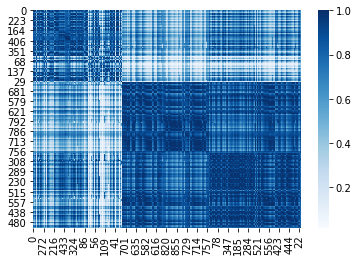

In [341]:
### The returned correlation matrix with clusters is:
sns.heatmap(corrNew,cmap = "Blues")



In [342]:
clstrsNew[0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 2

In [343]:

property_asel = [list(stationary_data.columns)[i] for i in clstrsNew[0]]

In [344]:
property_asel

['last_3_momentum',
 'rolling_3_avg_1_period_pct_change',
 'rolling_3_avg_2_period_pct_change',
 'rolling_3_avg_3_period_pct_change',
 'rolling_3_avg_4_period_pct_change',
 'rolling_3_avg_5_period_pct_change',
 'rolling_3_avg_6_period_pct_change',
 'rolling_3_avg_7_period_pct_change',
 'rolling_3_avg_8_period_pct_change',
 'rolling_3_avg_9_period_pct_change',
 'rolling_3_avg_10_period_pct_change',
 'rolling_3_avg_11_period_pct_change',
 'rolling_3_avg_12_period_pct_change',
 'rolling_3_avg_13_period_pct_change',
 'rolling_3_avg_14_period_pct_change',
 'rolling_3_avg_15_period_pct_change',
 'rolling_3_avg_16_period_pct_change',
 'rolling_3_avg_17_period_pct_change',
 'rolling_3_avg_18_period_pct_change',
 'rolling_3_avg_19_period_pct_change',
 'rolling_3_avg_20_period_pct_change',
 'rolling_3_avg_price_dif',
 'last_3_RSI',
 'last_4_momentum',
 'rolling_4_avg_1_period_pct_change',
 'rolling_4_avg_2_period_pct_change',
 'rolling_4_avg_3_period_pct_change',
 'rolling_4_avg_4_period_pct_cha

### Apply clustered ONC

In [345]:
def getTestData(n_features=100,n_informative=25,n_redundant=25,
    n_samples=10000,random_state=0,sigmaStd=.0):
    # generate a random dataset for a classification problem
    
    np.random.seed(random_state)
    X,y=make_classification(n_samples=n_samples,
    n_features=n_features-n_redundant,
    n_informative=n_informative,n_redundant=0,shuffle=False,
    random_state=random_state)
    cols=['I_'+str(i) for i in range(n_informative)]
    cols+=['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]
    X,y=pd.DataFrame(X,columns=cols),pd.Series(y)
    i=np.random.choice(range(n_informative),size=n_redundant)
    for k,j in enumerate(i):
        X['R_'+str(k)]=X['I_'+str(j)]+np.random.normal(size=X.shape[0])*sigmaStd
    return X,y

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in \
    enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),
    'std':df0.std()*df0.shape[0]**-.5},axis=1) # CLT
    imp/=imp['mean'].sum()
    return imp
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDA(clf,X,y,n_splits=10):
# feat importance based on OOS score reduction
    
    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0) # the fit occurs here
        prob=fit.predict_proba(X1) # prediction before shuffling
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # shuffle one column
            prob=fit.predict_proba(X1_) # prediction after shuffling
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT
    return imp


def groupMeanStd(df0,clstrs):
    out=pd.DataFrame(columns=['mean','std'])
    for i,j in clstrs.items():
        df1=df0[j].sum(axis=1)
        out.loc['C_'+str(i),'mean']=df1.mean()
        out.loc['C_'+str(i),'std']=df1.std()*df1.shape[0]**-.5
    return out
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDI_Clustered(fit,featNames,clstrs):
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=groupMeanStd(df0,clstrs)
    imp/=imp['mean'].sum()
    return imp


def featImpMDA_Clustered(clf,X,y,clstrs,n_splits=10):

    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=clstrs.keys())
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0)
        prob=fit.predict_proba(X1)
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in scr1.columns:
            X1_=X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) # shuffle cluster
            prob=fit.predict_proba(X1_)
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index=['C_'+str(i) for i in imp.index]
    return imp

In [368]:
from sklearn.datasets import make_classification
import numpy as np,pandas as pd,seaborn as sns
import statsmodels.discrete.discrete_model as sm
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
ols=sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


In [369]:
X

,I_0,I_1,I_2,I_3,I_4,N_0,N_1,N_2,N_3,N_4,...,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29
0,2.105359,2.861661,0.104159,0.686149,1.369429,-0.868903,-1.297125,-0.160205,-0.481024,0.841338,...,0.777001,2.207398,0.655435,2.142781,0.004543,0.815639,2.109815,2.762477,0.863380,0.588109
1,-0.330754,1.464379,-1.405119,0.396713,-1.722305,0.471952,-1.443687,-0.433773,0.123114,-0.102970,...,0.355247,-0.295893,0.445317,-0.376633,-1.364581,0.393410,-0.647636,1.561900,0.517651,0.460849
2,-0.461334,-0.160432,-2.169501,-0.137535,0.398229,-0.278979,-1.860566,0.909540,-0.396742,2.455228,...,-0.172824,-0.421676,-0.132882,-0.351309,-2.156682,-0.214241,-0.399131,-0.081916,-0.092813,-0.166722
3,-1.573667,3.110105,0.073939,1.232501,1.069429,0.700720,-1.097145,0.157145,-1.699373,1.167458,...,1.252339,-1.597342,1.275388,-1.518133,0.134187,1.259898,-1.494194,3.161966,1.228390,1.263964
4,0.528677,1.538982,-1.603758,2.056413,0.777722,-0.644594,-0.304476,0.682256,-0.644368,0.280994,...,2.074816,0.446280,2.047097,0.577832,-1.590869,2.006196,0.642976,1.371926,2.078883,2.085223
5,-1.016784,0.392428,0.819182,-1.035334,1.926106,-0.823116,0.341847,-0.964623,-0.944686,-1.131222,...,-0.925184,-1.143884,-1.147381,-1.043988,0.826888,-0.949607,-0.904478,0.221256,-0.810028,-1.094733
6,-2.604845,1.285505,0.863767,1.345883,-0.293193,0.295076,-2.099836,-0.962368,0.598353,-0.570690,...,1.317961,-2.665733,1.202128,-2.513139,1.009674,1.285473,-2.621481,1.281275,1.304884,1.286918
7,-1.382551,2.166110,-0.806347,1.239954,1.064073,-2.814916,-0.964434,-2.283037,-1.436235,-2.502739,...,1.374031,-1.224477,1.194678,-1.363223,-0.614802,1.208867,-1.290900,2.342602,1.299278,1.323259
8,-0.870055,1.575573,-0.344298,1.314229,0.778027,-1.011682,-1.388172,-1.080870,1.121351,-2.942603,...,1.362596,-0.949845,1.229368,-0.792501,-0.328317,0.987360,-0.914290,1.507483,1.154161,1.477920
9,-1.964977,2.649500,0.713661,0.546377,0.252199,-0.858016,0.886964,1.350457,1.648938,-2.036860,...,0.544821,-2.062416,0.568972,-1.964294,0.743769,0.630479,-1.983331,2.674828,0.645600,0.500437


In [380]:
X = stationary_data[one_pct_confidence_adf]
y = stationary_data[y_variables_actual]['forward_7_opportunity']
y = y.iloc[:,0].apply(lambda x: 1 if x>0 else 0 )

In [381]:
y

0       1
1       1
2       1
3       1
4       0
5       1
6       1
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      1
15      1
16      1
17      1
18      0
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
1912    0
1913    0
1914    0
1915    0
1916    0
1917    0
1918    0
1919    0
1920    0
1921    0
1922    0
1923    0
1924    0
1925    0
1926    0
1927    0
1928    0
1929    0
1930    0
1931    1
1932    1
1933    1
1934    1
1935    1
1936    1
1937    1
1938    0
1939    0
1940    0
1941    0
Name: forward_7_opportunity, Length: 1942, dtype: int64

In [382]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
max_features=1.,max_samples=1.,oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI(fit,featNames=X.columns)

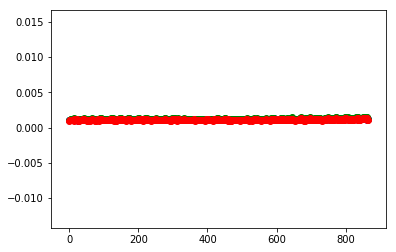

In [383]:
plt.scatter(range(len(imp)),imp['mean'],color = "blue")
plt.scatter(range(len(imp)),imp['mean'] + 2*imp['std'],color = "green")
plt.scatter(range(len(imp)),imp['mean'] - 2*imp['std'],color = "red")

0
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
1
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
2
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
3
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CLUSTERS FOR: 5
CHECKING CLUSTERS FOR: 6
CHECKING CLUSTERS FOR: 7
CHECKING CLUSTERS FOR: 8
CHECKING CLUSTERS FOR: 9
CHECKING CLUSTERS FOR: 10
4
CHECKING CLUSTERS FOR: 2
CHECKING CLUSTERS FOR: 3
CHECKING CLUSTERS FOR: 4
CHECKING CL

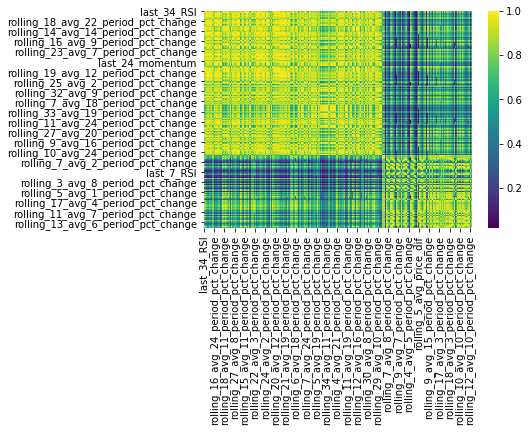

In [393]:
corr0,clstrs,silh=clusterKMeansBase(X.corr(),maxNumClusters=10,
n_init=10)
sns.heatmap(corr0,cmap='viridis')
#ONC correctly recognizes that there are six relevant
#clusters (one cluster for each informative feature, plus one cluster of noise features),
#and it assigns the redundant features to the 

In [399]:
x_dic.items()

dict_items([('momentum', <function calc_momentum at 0x000001AC82F9FC80>), ('rolling_avg_pct_change', <function calc_rolling_avg_pct_change at 0x000001AC82A88D90>), ('rolling_avg', <function calc_rolling_avg at 0x000001AC82A88F28>), ('rolling_avg_price_dif', <function calc_rolling_avg_price_dif at 0x000001AC82A64048>), ('RSI', <function calc_RSI at 0x000001AC82A640D0>)])

In [409]:
cluster_list = list(stationary_data.columns)


In [410]:
cluster_list.sort()

In [411]:
cluster_list

['forward_10_opportunity',
 'forward_11_opportunity',
 'forward_12_opportunity',
 'forward_13_opportunity',
 'forward_14_opportunity',
 'forward_15_opportunity',
 'forward_16_opportunity',
 'forward_17_opportunity',
 'forward_18_opportunity',
 'forward_19_opportunity',
 'forward_20_opportunity',
 'forward_21_opportunity',
 'forward_22_opportunity',
 'forward_23_opportunity',
 'forward_24_opportunity',
 'forward_25_opportunity',
 'forward_26_opportunity',
 'forward_27_opportunity',
 'forward_28_opportunity',
 'forward_29_opportunity',
 'forward_30_opportunity',
 'forward_31_opportunity',
 'forward_32_opportunity',
 'forward_33_opportunity',
 'forward_34_opportunity',
 'forward_3_opportunity',
 'forward_4_opportunity',
 'forward_5_opportunity',
 'forward_6_opportunity',
 'forward_7_opportunity',
 'forward_7_opportunity',
 'forward_7_opportunity',
 'forward_7_opportunity',
 'forward_8_opportunity',
 'forward_9_opportunity',
 'last_10_RSI',
 'last_10_momentum',
 'last_11_RSI',
 'last_11_mo

In [394]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
max_features=1.,max_samples=1.,oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI_Clustered(fit,X.columns,clstrs)

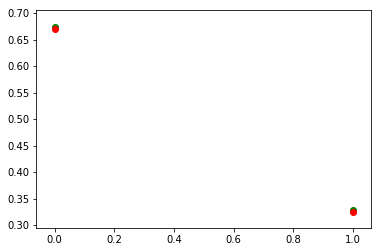

In [395]:
plt.scatter(range(len(imp)),imp['mean'],color = "blue")
plt.scatter(range(len(imp)),imp['mean'] + 2*imp['std'],color = "green")
plt.scatter(range(len(imp)),imp['mean'] - 2*imp['std'],color = "red")
## We can see from the scatter below that of the six clusters, the first 5 are presented as the most significant.
## the confidence intervals are also very tight.

In [27]:
for key,item in clstrs.items():
    print(key
         )
    print(len(item))

NameError: name 'clstrs' is not defined